# Objetivo


Se trata de uma empresa que quer prever sua futura receita líquida pelos próximos 6 meses. O objetivo é realizar um algoritmo de previsão e trazer insights sobre o negócio.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



from statsmodels.tsa.arima.model import ARIMA

# Data Understanding

In [3]:
df = pd.read_csv('Dataset_cliente.csv',sep = ';')
df

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,W51,0,40,1
715871,170503,Paid Marketing,2015,W25,9,37,1
715872,169910,Referral,2015,W04,37,37,1
715873,542301,Paid Marketing,2015,W11,56,56,1


* customer_id - Id do cliente
* customer_acquisition_channel - Canal que o cliente utilizou para fazer a aquisição
* year - ano
* week - semana
* net_revenue - receita líquida
* gross_revenue - receita bruta
* boxes - número de caixas

# Data preparation

In [4]:
# verificando valores duplicados
df.duplicated().sum()

0

In [5]:
# Verificando existência de valores nulos
df.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
week                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
dtype: int64

In [6]:
# Estatística descritiva
df.describe()

,customer_id,year,net_revenue,gross_revenue,boxes
count,715875.000000,715875.000000,715875.000000,715875.000000,715875.000000
mean,323664.862498,2014.196999,36.415437,41.430585,1.034697
std,186136.720066,0.754568,13.646022,9.752502,0.190199
min,103.000000,2013.000000,0.000000,14.000000,1.000000
25%,159325.000000,2014.000000,37.000000,37.000000,1.000000
50%,289541.000000,2014.000000,37.000000,37.000000,1.000000
75%,476431.000000,2015.000000,37.000000,40.000000,1.000000
max,746721.000000,2015.000000,532.000000,532.000000,17.000000


Os anos estão de 2013 até 2015.
Existe uma discrepância de alta do maior pro menor em relação à receita bruta e líquida. Como o desvio padrão está bem baixo, pode ser um sinal de muitos outliers altos.

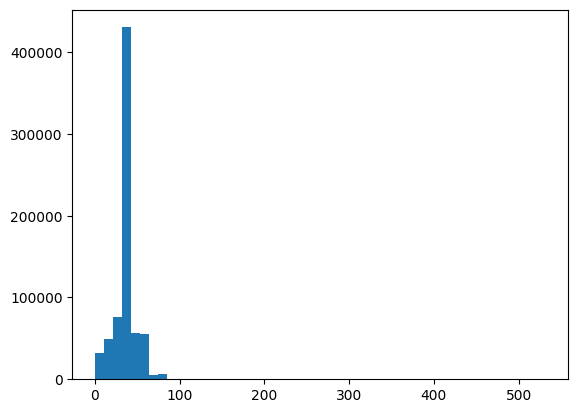

In [7]:
plt.hist(df['net_revenue'],bins=50)
plt.show()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_16504\438721164.py:3: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.boxplot(data=df[(df['net_revenue']<100) & (df['gross_revenue']<100)].drop(columns=['customer_id','year']),palette = colors)


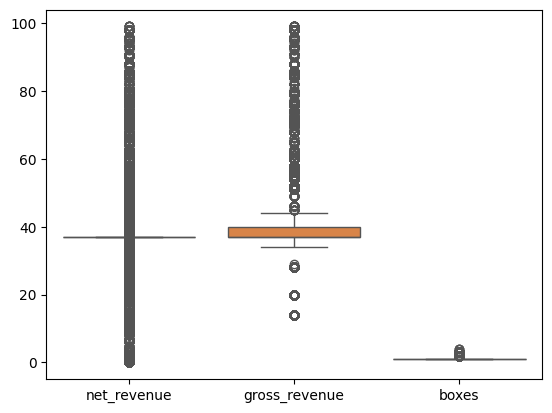

In [8]:
colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']

sns.boxplot(data=df[(df['net_revenue']<100) & (df['gross_revenue']<100)].drop(columns=['customer_id','year']),palette = colors)
plt.show()

São inúmeros valores próximos de 40. Mas como existem valores de lucro 0, precisa ser avaliado


In [9]:
df['tax'] = df['gross_revenue'] - df['net_revenue']
df['tax'].describe()

count    715875.000000
mean          5.015148
std           9.798479
min          -1.000000
25%           0.000000
50%           0.000000
75%           9.000000
max         112.000000
Name: tax, dtype: float64

Existem valores com taxas muito altas. Precisaria de mais dados do clientes para realizar uma análise  mais profunda pra entender se são erros ou não.

In [10]:
# Transformando semana e ano em data
    # retirando W de coluna para transformar em número
df['week'] = df['week'].str.replace('W','')
df['week']

0         09
1         25
2         50
3         42
4         29
          ..
715870    51
715871    25
715872    04
715873    11
715874    50
Name: week, Length: 715875, dtype: object

In [11]:
df['year']

0         2014
1         2015
2         2015
3         2013
4         2014
          ... 
715870    2015
715871    2015
715872    2015
715873    2015
715874    2015
Name: year, Length: 715875, dtype: int64

In [12]:
# Converter ano e semana em datas
def week_to_date_alternative(year, week_int):
    # O ano começa na semana 1
    first_week_start = datetime.strptime(f'{year}-W{int(week_int)-1}-1', "%Y-W%W-%w")
    return first_week_start

# Aplicar a função alternativa
df['date'] = df.apply(lambda row: week_to_date_alternative(row['year'], row['week']), axis=1)

# Agrupar os dados por data e somar a net_revenue
time_series_data = df.groupby('date')['net_revenue'].sum().reset_index()

# Ordenar os dados por data
time_series_data = time_series_data.sort_values(by='date')

# Exibir as primeiras linhas da série temporal
time_series_data.head()

,date,net_revenue
0,2013-01-07,2310
1,2013-01-14,12342
2,2013-01-21,25807
3,2013-01-28,35713
4,2013-02-04,41898


# Data Analysis

### Resultados de Vendas por ano

In [13]:
# Agrupando por ano e somando os valores da receita
vendas_anuais = df.groupby(df['year'])[['net_revenue','gross_revenue','boxes']].sum()
vendas_anuais

,net_revenue,gross_revenue,boxes
year,,,
2013,5295828,6134328,156289
2014,10161460,11505225,291647
2015,10611613,12019567,292778


In [14]:
plt.figure(figsize = (10,8))
px.histogram(vendas_anuais , x = vendas_anuais.index, y =["net_revenue","gross_revenue"],color_discrete_sequence=["darkturquoise","slateblue","purple"],barmode = 'group', title = 'Faturamento Anual',height=700,text_auto='.2s')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'variable=net_revenue<br>year=%{x}<br>sum of value=%{y}<extra></extra>',
              'legendgroup': 'net_revenue',
              'marker': {'color': 'darkturquoise', 'pattern': {'shape': ''}},
              'name': 'net_revenue',
              'offsetgroup': 'net_revenue',
              'orientation': 'v',
              'showlegend': True,
              'texttemplate': '%{value:.2s}',
              'type': 'histogram',
              'x': array([2013, 2014, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([ 5295828, 10161460, 10611613], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'variable=gross_revenue<br>year=%{x}<br>sum of value=%{y}<extra></extra>',
              'legendgroup': 'gross_revenue',
              'marker': {'color': 'slateblue', 'pattern': {'shape': ''}},
              'name': 'gross_revenue',
              'offsetgroup': 'gross_revenue',
              'orientation': 'v',
              'showlegend': True,
              'texttemplate': '%{value:.2s}',
              'type': 'histogram',
              'x': array([2013, 2014, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([ 6134328, 11505225, 12019567], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'barmode': 'group',
               'height': 700,
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Faturamento Anual'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'year'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'sum of value'}}}
})

<Figure size 1000x800 with 0 Axes>

O Crescimento de receita de 2013 para 2014 é nitido graficamente. De 2014 para 2015 a receita bruta se mantêve. Apesar disso, o lucro líquido aumentou também, mostrando que alguns custos que diminuiam a receita aparentemente foram reduzidos. Já que o número de boxes vendidos foi muito parecidos entre 2014 e 2015.

### Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

In [15]:
# núnero de vendas de cada um dos canais

n_vendas_canal  = df.groupby(['year','customer_acquisition_channel']).count()
n_vendas_canal

customer_id    week  net_revenue  \
year customer_acquisition_channel                                     
2013 Paid Marketing                     121299  121299       121299   
     Referral                            25878   25878        25878   
2014 Paid Marketing                     227005  227005       227005   
     Referral                            53489   53489        53489   
2015 Paid Marketing                     214637  214637       214637   
     Referral                            73567   73567        73567   

                                   gross_revenue   boxes     tax    date  
year customer_acquisition_channel                                         
2013 Paid Marketing                       121299  121299  121299  121299  
     Referral                              25878   25878   25878   25878  
2014 Paid Marketing                       227005  227005  227005  227005  
     Referral                              53489   53489   53489   53489  
2015 Paid Marketing                       214637  214637  214637  214637  
     Referral                              73567   73567   73567   73567

In [18]:
best_channell  = df.groupby(['year','customer_acquisition_channel']).sum()

TypeError: datetime64 type does not support sum operations

In [19]:
# Separando o melhor canal
best_channell = df.groupby(['year','customer_acquisition_channel'])[['net_revenue','gross_revenue','boxes']].sum()
best_channell


net_revenue  gross_revenue   boxes
year customer_acquisition_channel                                    
2013 Paid Marketing                    4489272        5103819  129679
     Referral                           806556        1030509   26610
2014 Paid Marketing                    8440431        9385996  237085
     Referral                          1721029        2119229   54562
2015 Paid Marketing                    8169031        9023314  218626
     Referral                          2442582        2996253   74152

In [20]:

# Criando feature de ticket Médio no dataset
best_channell['Ticket_Medio'] = best_channell['gross_revenue'] /n_vendas_canal['gross_revenue']
best_channell.reset_index(inplace =True)

best_channell.head()

,year,customer_acquisition_channel,net_revenue,gross_revenue,boxes,Ticket_Medio
0,2013,Paid Marketing,4489272,5103819,129679,42.076349
1,2013,Referral,806556,1030509,26610,39.821818
2,2014,Paid Marketing,8440431,9385996,237085,41.347089
3,2014,Referral,1721029,2119229,54562,39.619903
4,2015,Paid Marketing,8169031,9023314,218626,42.039881


In [23]:
# Viz
plt.figure(figsize = (10,8))
px.histogram(best_channell , x = best_channell["year"], y =best_channell["Ticket_Medio"],color_discrete_sequence=["darkturquoise","slateblue","purple"],barmode = 'group', title = 'Ticket Médio dos canais por ano',height=700,text_auto='.2s',color = 'customer_acquisition_channel')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': ('customer_acquisition_channel=P' ... 'cket_Medio=%{y}<extra></extra>'),
              'legendgroup': 'Paid Marketing',
              'marker': {'color': 'darkturquoise', 'pattern': {'shape': ''}},
              'name': 'Paid Marketing',
              'offsetgroup': 'Paid Marketing',
              'orientation': 'v',
              'showlegend': True,
              'texttemplate': '%{value:.2s}',
              'type': 'histogram',
              'x': array([2013, 2014, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([42.07634853, 41.34708927, 42.03988129]),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': ('customer_acquisition_channel=R' ... 'cket_Medio=%{y}<extra></extra>'),
              'legendgroup': 'Referral',
              'marker': {'color': 'slateblue', 'pattern': {'shape': ''}},
              'name': 'Referral',
              'offsetgroup': 'Referral',
              'orientation': 'v',
              'showlegend': True,
              'texttemplate': '%{value:.2s}',
              'type': 'histogram',
              'x': array([2013, 2014, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([39.82181776, 39.61990316, 40.72822053]),
              'yaxis': 'y'}],
    'layout': {'barmode': 'group',
               'height': 700,
               'legend': {'title': {'text': 'customer_acquisition_channel'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Ticket Médio dos canais por ano'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'year'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'sum of Ticket_Medio'}}}
})

<Figure size 1000x800 with 0 Axes>

### Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)



In [24]:
# Quantidade de clientes únicos em cada ano
unicos=df
unicos['Freq'] = df.groupby('customer_id')['customer_id'].transform('count')
unicos = unicos[unicos['Freq'] ==1 ]
unicos= unicos.groupby('year').count()['customer_id'].reset_index()

unicos = unicos.rename({'customer_id': 'clientes_unicos'}, axis=1)
unicos



,year,clientes_unicos
0,2013,7542
1,2014,12851
2,2015,13078


In [27]:
# Viz

plt.figure(figsize = (10,8))
px.bar(unicos , y = "clientes_unicos", x ="year" ,title = 'Quantidade de Clientes Únicos por ano',height=800,text_auto='.3s',color_discrete_sequence=["slateblue","purple"])




ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'year=%{x}<br>clientes_unicos=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': 'slateblue', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'texttemplate': '%{y:.3s}',
              'type': 'bar',
              'x': array([2013, 2014, 2015], dtype=int64),
              'xaxis': 'x',
              'y': array([ 7542, 12851, 13078], dtype=int64),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'height': 800,
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Quantidade de Clientes Únicos por ano'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'year'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'clientes_unicos'}}}
})

<Figure size 1000x800 with 0 Axes>

### Comportamento da série ao longo do tempo


[]

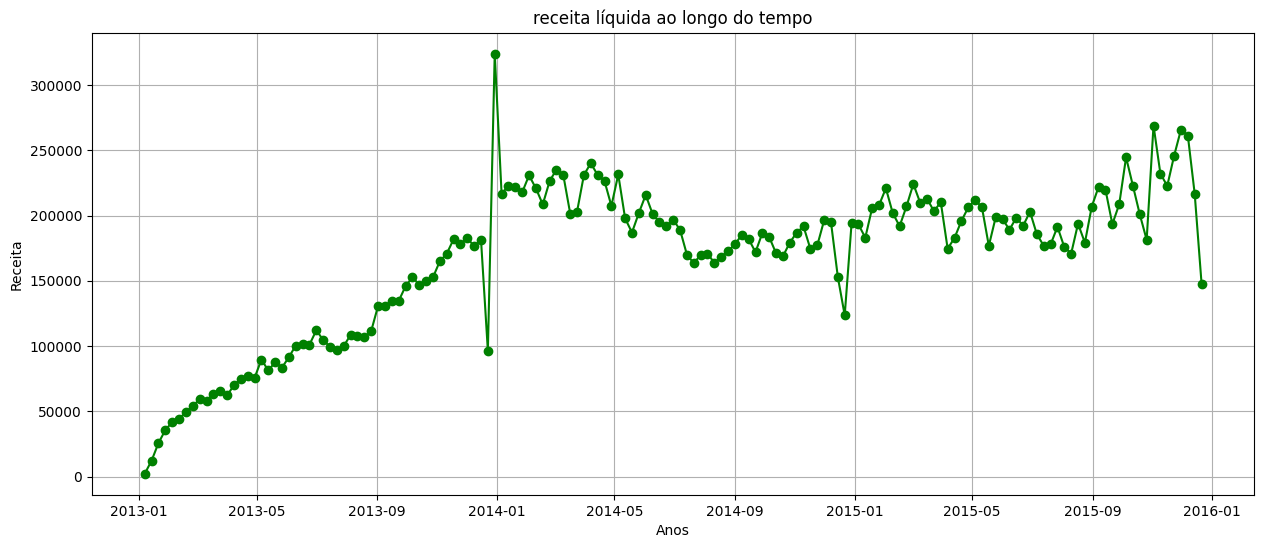

In [13]:
plt.figure(figsize = (15,6))
plt.plot(time_series_data['date'], time_series_data['net_revenue'], marker='o', linestyle='-',color='green')
plt.title('receita líquida ao longo do tempo')
plt.xlabel('Anos')
plt.ylabel('Receita')
plt.grid(True)
plt.plot()



A empresa passou por uma boa crescente de 2013 para 2014 e se manteve crescendo bem devagar até o final de 2015. Ao final de 2014 acontece uma queda brusca e logo depois tem uma alta aguda e aparentemente os dados estão se comportando de forma parecida com o decorrer do tempo. Isso pode ser um bom indício de sazonalidade.

# Model

## teste de sazonalidade

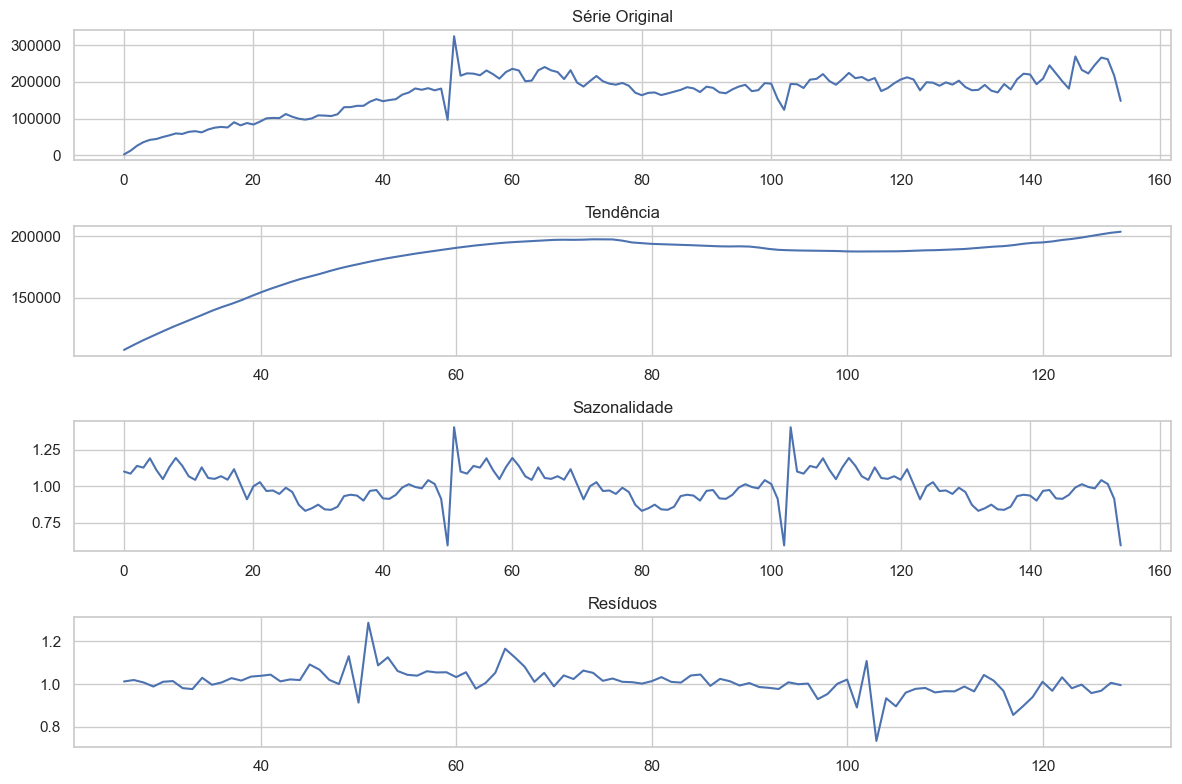

In [14]:
# Configurando o estilo dos gráficos
sns.set(style="whitegrid")
# Agrupando os dados por data e calculando a receita líquida total por semana
weekly_revenue = df.groupby('date').agg({'net_revenue': 'sum'}).reset_index()
# Decompondo a série temporal
decomposition = seasonal_decompose(weekly_revenue['net_revenue'], model='multiplicative', period=52)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Série Original')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Tendência')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Resíduos')
plt.tight_layout()
plt.show()

* Série Original: Este é o gráfico da série temporal de dados original, mostra as flutuações ao longo do tempo. Podemos observar que existem variações periódicas e alguns picos e vales ao longo da série.
* Tendência: O gráfico de tendência mostra como a série temporal evolui ao longo do tempo, excluindo a sazonalidade e o ruído. Há uma tendência geral de aumento, indicando que há um crescimento ou uma tendência ascendente na série ao longo do período observado. Exatamente como havíamos pontuado antes!
* Sazonalidade: Este componente revela padrões que se repetem em intervalos regulares. O gráfico da sazonalidade não mostra um padrão claro e repetitivo, sugerindo que a sazonalidade pode não ser um fator significativo na série temporal ou que o período de sazonalidade pode não estar bem capturado.
* Resíduos: Este gráfico mostra o que resta da série temporal após a remoção da tendência e da sazonalidade. Os resíduos representam a flutuação aleatória que não pode ser explicada pelos modelos de tendência ou sazonalidade. O ideal é que os resíduos pareçam ser ruído branco, ou seja, sem padrões discerníveis, o que indicaria que a tendência e a sazonalidade foram bem capturadas nos outros componentes.

In [53]:
# Realizando o teste ADF na série temporal 'net_revenue'
adf_test_result = adfuller(time_series_data['net_revenue'])

# Criando um DataFrame para exibir os resultados do teste de forma mais clara

adf_results = pd.DataFrame({
    'Item': [
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used',
        'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'
    ],
    'Value': [
        adf_test_result[0],  # Test statistic
        adf_test_result[1],  # p-value
        adf_test_result[2],  # #Lags Used
        adf_test_result[3],  # Number of Observations Used
        adf_test_result[4]['1%'],  # Critical Value for 1%
        adf_test_result[4]['5%'],  # Critical Value for 5%
        adf_test_result[4]['10%']  # Critical Value for 10%
    ]
})

adf_results

,Item,Value
0,Test Statistic,-2.160242
1,p-value,0.220990
2,#Lags Used,10.000000
3,Number of Observations Used,144.000000
4,Critical Value (1%),-3.476598
5,Critical Value (5%),-2.881829
6,Critical Value (10%),-2.577589


Para série ser estacionária o p-value tem que ser menor que 0.05 e isso acontece por conta da rejeição de hipótese nula. Portanto, a série não é estacionária e nossa previsão ficaria ruim caso isso permanecesse assim. 

Realizarei a diferenciação na série temporal pra testar novamente a sua estacionariedade.

In [74]:
# Diferenciação

time_series_data['diff_net_revenue'] = time_series_data['net_revenue'].diff().fillna(0)

# Realizar o teste ADF na série temporal 'net_revenue'
adf_test_result_diff = adfuller(time_series_data['diff_net_revenue'])

# Criar um DataFrame para exibir os resultados do teste de forma mais clara
# Incluindo os valores críticos
adf_test_result_diff = pd.DataFrame({
    'Item': [
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used',
        'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'
    ],
    'Value': [
        adf_test_result[0],  # Test statistic
        adf_test_result[1],  # p-value
        adf_test_result[2],  # #Lags Used
        adf_test_result[3],  # Number of Observations Used
        adf_test_result[4]['1%'],  # Critical Value for 1%
        adf_test_result[4]['5%'],  # Critical Value for 5%
        adf_test_result[4]['10%']  # Critical Value for 10%
    ]
})

adf_test_result_diff

,Item,Value
0,Test Statistic,-3.397802
1,p-value,0.011034
2,#Lags Used,9.000000
3,Number of Observations Used,145.000000
4,Critical Value (1%),-3.476273
5,Critical Value (5%),-2.881688
6,Critical Value (10%),-2.577513


O p-value já está abaixo de 0.05 (0.011) e isso já mostra que a série é estacionária.
A estatística do teste de -3.397802 é mais negativa que o valor crítico de 5% e 10%, mas não é mais negativa que o valor crítico de 1%. Isso significa que você pode rejeitar a hipótese nula com um nível de confiança de 90% e 95%, mas não com um nível de confiança de 99%.
Portanto, há evidências suficientes para concluir que a série temporal é estacionária com um nível de confiança de até 95%. Isso é reforçado pelo valor-p de 0.011034, que está abaixo do limiar comum de 0.05, indicando que a hipótese nula pode ser rejeitada e que a série é estacionária.

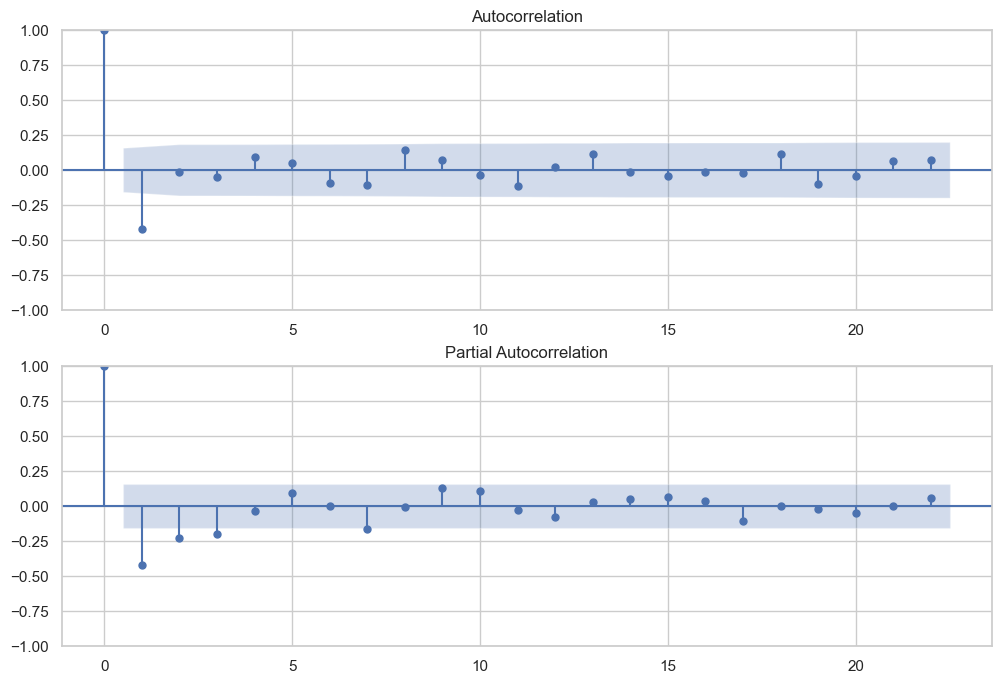

In [75]:
# Plotando ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelação
plot_acf(time_series_data['diff_net_revenue'], ax=ax1)

# Autocorrelação Parcial
plot_pacf(time_series_data['diff_net_revenue'], ax=ax2, method='ywm')

plt.show()

A escolha dos valores de p e q são escolhidos de acordo com o gráfico ACF e PACF.
Como ouve uma queda exponencial do primeiro ponto, escolhemos os valores pelo número de pontos que cortam a faixa de confiança antes de voltar para dentro

Vamos interpretar os resultados do modelo.
* AIC e BIC: São medidas de comparação. Você pode trocar os valores de p, d e q e ver como estas métricas se comportam. Quanto menor, melhor está o modelo.
* Coeficientes: basicamente você deve olhar para cada coeficiente e analisar o p-value do mesmo, se for maior que 0.05, a hipótese nula é rejeitada e o valor perde significância. 
* ar.L1: O coeficiente para o primeiro termo AR é -0.9256, significativo (p < 0.05).
* ma.L1: O coeficiente para o primeiro termo MA é 0.5251, mas não é significativo (p > 0.05).
* ma.L2: O coeficiente para o segundo termo MA é -0.5593, próximo da significância (p = 0.055).
* ma.L3: O coeficiente para o terceiro termo MA é -0.2006, não significativo (p > 0.05).
* ar.S.L52: O coeficiente para o termo AR sazonal é -0.6978, significativo (p < 0.05).
* Ljung-Box Test: Um teste de autocorrelação que verifica se há padrões não aleatórios em uma série de dados, neste caso, os resíduos (erros) do modelo. Se o valor p for maior que 0.05, normalmente aceitamos que os resíduos não têm autocorrelações significativas, ou seja, parecem ser aleatórios, o que é bom para o modelo.
* Jarque-Bera (JB): Um teste que avalia se a distribuição dos resíduos do seu modelo é semelhante a uma distribuição normal.O valor p é 0.00, o que significa que podemos rejeitar a hipótese de que os resíduos seguem uma distribuição normal. Isso pode ser um problema porque muitos testes e intervalos de confiança assumem que os erros são normalmente distribuídos.
* Teste de Heteroscedasticidade: Um teste que verifica se a variância dos resíduos é constante ao longo do tempo. Se a variância muda ao longo do tempo, os resíduos são heteroscedásticos, o que pode ser um sinal de que o modelo não está capturando toda a variabilidade dos dados.O valor p é 0.83, o que é bem acima de 0.05, sugerindo que não há evidências de heteroscedasticidade nos resíduos. Isso indica que a variância dos erros é consistente ao longo do tempo, o que é bom.

* Aderência do Modelo: Em geral, a linha vermelha segue de perto a linha azul, o que indica que o modelo está capturando a tendência geral da série temporal razoavelmente bem. A proximidade entre as duas linhas ao longo da série indica que o modelo tem uma boa aderência na maior parte do tempo. Isso significa que o modelo está conseguindo prever a direção e a magnitude das mudanças na receita ao longo do tempo.
* Variações: Há flutuações regulares que parecem ser capturadas pelo modelo, sugerindo que a sazonalidade foi bem modelada. Existem pontos onde a previsão parece mais volátil do que os dados reais, particularmente em torno dos picos e vales. Isso pode indicar que o modelo pode estar reagindo demais a variações pontuais ou que há aspectos da volatilidade dos dados que o modelo atual não está capturando completamente.
* Picos e Quedas: O modelo parece reagir aos picos nos dados reais, embora não capture completamente a intensidade de alguns deles (por exemplo, o pico acentuado no início da série). De maneira semelhante, o modelo parece acompanhar as quedas nos dados reais, mas com algumas diferenças notáveis em magnitude.

In [28]:
# Configuração inicial dos parâmetros p, d, q
# Estes valores podem precisar ser ajustados com base na análise dos gráficos ACF e PACF
p = 1  # ordem do componente autoregressivo
d = 1  # ordem de diferenciação
q = 1  # ordem do componente de média móvel

# Modelo SARIMAX
model = SARIMAX(time_series_data['net_revenue'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         net_revenue   No. Observations:                  155
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1141.210
Date:                             Sat, 25 Nov 2023   AIC                           2290.419
Time:                                     13:24:13   BIC                           2300.919
Sample:                                          0   HQIC                          2294.671
                                             - 155                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2206      0.386      0.571      0.568      -0.536       0.978
ma.L1         -0.6920      

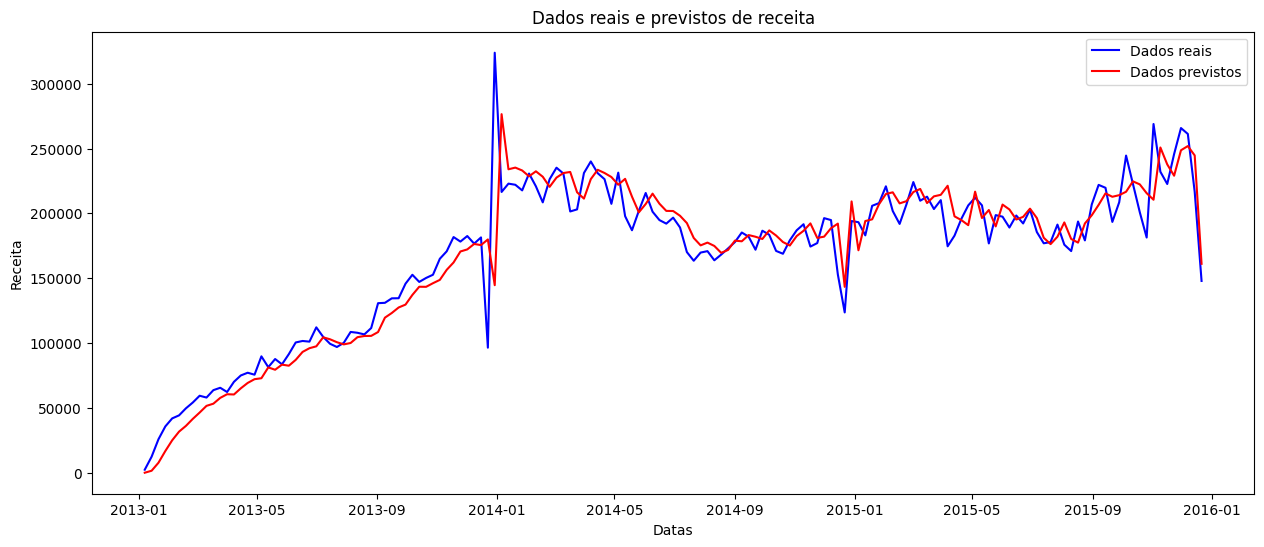

In [30]:
predictions = model_fit.get_prediction(start=0, end=len(time_series_data) - 1)
predicted_means = predictions.predicted_mean
predicted_dates = time_series_data['date'] 



# Plotando os dados históricos e as previsões
plt.figure(figsize=(15, 6))
plt.plot(time_series_data['date'], time_series_data['net_revenue'], label='Dados reais', color='blue')
plt.plot(predicted_dates,predicted_means,label = 'Dados previstos',color ='red')
plt.title('Dados reais e previstos de receita')
plt.xlabel('Datas')
plt.ylabel('Receita')
plt.legend()
plt.show()

In [31]:
# Previsões
future_dates = [time_series_data['date'].iloc[-1] + DateOffset(weeks=x) for x in range(1, 27)]
forecast_object = model_fit.get_forecast(steps=26)
confianca = forecast_object.conf_int()

forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_net_revenue': forecast_object.predicted_mean,
    'lower_confidence': confianca.iloc[:, 0],
    'upper_confidence': confianca.iloc[:, 1]
})

forecast_df

,date,predicted_net_revenue,lower_confidence,upper_confidence
155,2015-12-28,334271.216738,289561.457701,378980.975775
156,2016-01-04,262707.872346,212136.641167,313279.103525
157,2016-01-11,264284.731594,210268.111454,318301.351734
158,2016-01-18,271030.829326,214107.606895,327954.051757
159,2016-01-25,268765.354414,209144.580463,328386.128365
160,2016-02-01,281748.569295,219561.330204,343935.808387
161,2016-02-08,268965.521298,204316.627146,333614.415451
162,2016-02-15,257361.472361,190341.919245,324381.025476
163,2016-02-22,274357.187744,205048.151150,343666.224338
164,2016-02-29,285860.468015,214335.224698,357385.711332


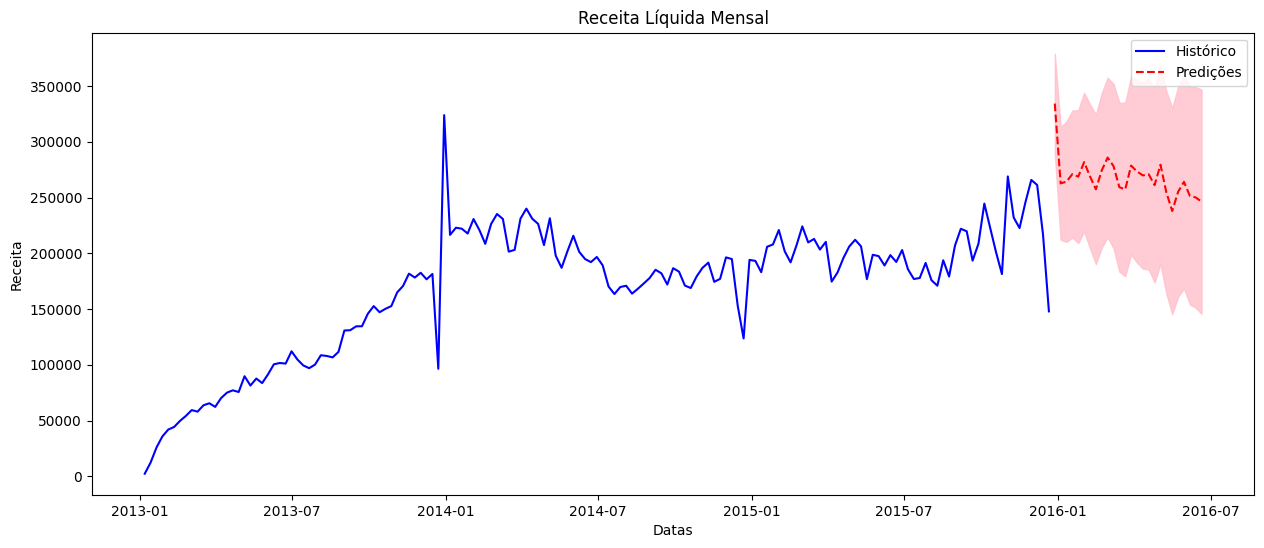

In [32]:
# Plotando os dados históricos e as previsões
plt.figure(figsize=(15, 6))
plt.plot(time_series_data['date'], time_series_data['net_revenue'], label='Histórico', color='blue')
plt.plot(forecast_df['date'], forecast_df['predicted_net_revenue'], label='Predições', color='red', linestyle='--')
# Adicionando intervalo de confiança
plt.fill_between(forecast_df['date'],forecast_df['lower_confidence'],forecast_df['upper_confidence'], color='pink', alpha=0.8)
plt.title('Receita Líquida Mensal')
plt.xlabel('Datas')
plt.ylabel('Receita')
plt.legend()
plt.show()

Estão no plot e na tabela os dados da previsão dos próximos 6 meses.
Aparentemente o padrão segue a sazonalidade do fim de 2014 seguindo a tendência de crescimento ao longo do tempo.
Ainda sim, o ano de 2015 se mostrou bastante conturbado seria uma boa ideia testar novas estratégias.
O número de clientes que compraram uma única vez aumentou de 2013 para 2014 e se manteve de 2014 para 2015. Então pode ser viável criar estratégias de fidelização e tentar diminuir este valor.
Os dois meios de aquisição do cliente competem muito bem entre si. Abrir oprtunidade para um novo meio pode abrir portas para novos clientes.

## Alternativa usando variáveis exógenas

c:\Users\Pichau\Desktop\Projetos Python\Time series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Pichau\Desktop\Projetos Python\Time series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Pichau\Desktop\Projetos Python\Time series\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


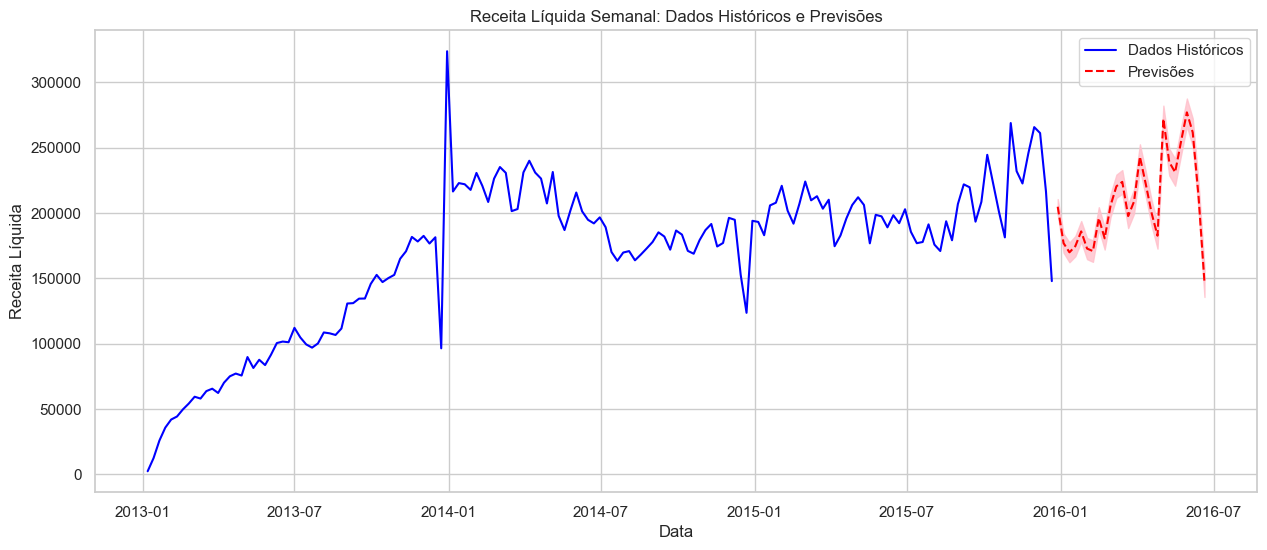

In [242]:
df_exog = time_series_data[['date']].merge(df[['date','gross_revenue', 'boxes']].groupby('date').sum(), on='date', how='left').fillna(0)

# Separar a série temporal e as variáveis exógenas
ts = time_series_data.set_index('date')['net_revenue']
exog = df_exog.set_index('date')[['gross_revenue', 'boxes']]

# Redefinindo o modelo SARIMAX com as variáveis exógenas
# Parâmetros SARIMA: (1, 1, 1), (1, 1, 1, 52)
model_exog = SARIMAX(ts, order=(1, 1, 3), seasonal_order=(1, 1, 1, 52), exog=exog)
model_fit_exog = model_exog.fit(disp=False)

# Previsões para os próximos 6 meses (26 semanas)
future_dates_exog = [time_series_data['date'].iloc[-1] + DateOffset(weeks=x) for x in range(1, 27)]
forecast_exog = model_fit_exog.get_forecast(steps=26, exog = exog.iloc[-26:])
confianca_exog = forecast_exog.conf_int()


# Criando dataset com os valores futuros colhidos
forecast_df_exog = pd.DataFrame({
    'date': future_dates_exog,
    'predicted_net_revenue': forecast_exog.predicted_mean,
    'lower_confidence': confianca_exog.iloc[:, 0],
    'upper_confidence': confianca_exog.iloc[:, 1]
})

# Plotando os dados históricos e as previsões
plt.figure(figsize=(15, 6))
plt.plot(time_series_data['date'], time_series_data['net_revenue'], label='Dados Históricos', color='blue')
plt.plot(forecast_df_exog['date'], forecast_df_exog['predicted_net_revenue'], label='Previsões', color='red', linestyle='--')
plt.fill_between(forecast_df_exog['date'],forecast_df_exog['lower_confidence'],forecast_df_exog['upper_confidence'], color='pink', alpha=0.8)
plt.title('Receita Líquida Semanal: Dados Históricos e Previsões')
plt.xlabel('Data')
plt.ylabel('Receita Líquida')
plt.legend()
plt.show()

Apesar do intervalo de confiança ser bem mais estreito do que o anterior e isso soar que o modelo está mais encaixado, temos que primeiro reparar em outras características. 
Se reparar bem, o modelo não capturou muito bem a sazonalidade anual , principalmente porque a quantidade de dados é pequena e porque realmente não existe um padrão que se repete. Mas o fato de que no fim de 2014 teve uma queda brusca e no início de 2015 uma subida acentuada, nos faz pensar que a mesma coisa vai acontecer de 2015 pra 2016, e isso se torna mais sólido vendo que existe uma queda eminente nos dados que temos.
Entretando, o modelo com variáveis exógenas parece capturar o final de 2015 como uma sazonalidade e projeta este mesmo padrão para os dados futuros.



Eu explico isso o código todo e minha linha de raciocínio de forma mais elaborada no meu artigo no medium que fiz sobre este projeto
Link: